# Google Dino Game using image recognition

### This is an aim to modify how one plays the dinosaur game by google. It would be highly advisable to read through the entire notebook before running it. Detailed steps and descriptions have been provided at each step which aid the reader in their journey through the notebook. 

In [1]:
# For performing mathematical operations. Specifically for using numpy arrays.
import numpy as np

In [2]:
# The opencv library which is the heart of this project.
import cv2

In [3]:
# The python auto GUI helps us to access the buttons, mouse, keyboard and the likes without actually interacting with them.
import pyautogui

In [4]:
# Internally used by the cv2.line method used at the last.
import math

In [9]:
# The code below is to start the camera which is represented by index 0 in the system. The camera begins and captures each frame.
cam = cv2.VideoCapture(0)
while cam.isOpened():
    success, frame = cam.read()
#     We read each frame. Success represents whether or not the frame capture was successful.
    begin = (100, 100) 
    end = (350, 350)
    colorBGR = (0, 255, 0)
    thickness = 0
    
#     The green stationary rectangle that we drew has the coordinate of 100,100 as its upper left corner.
    cv2.rectangle(frame, begin, end, colorBGR, thickness)
    
#     The original frame is cropped so that only the data inside of the rectangle specified above can be read and computations
#     can be more precise
    cropped_img = frame[100:350, 100:350]
    
#     We made a shallow copy of the cropped frame. Any and all computation that will be performed on the cropped_img
#     list will also be visible in frame since they both point to the same object.
    
#     Blurring the cropped image so that we can remove the unnecessary details.
    blurred_img = cv2.GaussianBlur(cropped_img, (3, 3), 0)
    
#   using the opencv library becomes much easier if we adopt the HSV colouring scheme instead of the usual rgb we find.
#   opencv uses BGR and HSV mainly. 
#   Here HSV stands for Hue, Saturation and Value
#   For the above stated reasons we convert the frame from the usual BGR(in openCV) to the HSV format.
    hsv = cv2.cvtColor(blurred_img, cv2.COLOR_BGR2HSV)
    
#---------<NOT IMPORTANT -- For documentation purposes only>    
    print_hsv = hsv
#---------</NOT IMPORTANT -- For documentation purposes only>    
#   You can print the above image using the cv2.imshow method to see how your image is rendered.

#   What has been done in the following line of code is also called thresholding. What we've basically done is that anything
#   which is in the HSV range provided will be converted to a 1(white pixel) and everything which falls on either of the 
#   2 extreme sides of the range will be given the value of 0(black pixel). This method called thresholding produces an i
#   image which is often called the mask. This is a binary image having only black and white pixels.
#   This HSV range represents my skin colour. What I'm telling the code is that register only my skin and ignore
#   everything else. You can tweak around with the values and set them according to your skin tone and lighting conditions
    mask = cv2.inRange(hsv, np.array([0,48,30]), np.array([20,255,255]))
    
#---------<NOT IMPORTANT -- For documentation purposes only>
    print_mask = mask
#---------</NOT IMPORTANT -- For documentation purposes only>
# You should try looking at the mask in of your hand if the output is not as expected. Your hand should be the only white
# everything else should be black.
#     cv2.imshow("img", mask)   

# Applying morphological transformations to filter out the background noise.
# One should read the docs to completely understand the under

    kernel = np.ones((5, 5))

    # It makes more sense to use dilation after we erode the unnecessary details. However, the output of this project
    # is much better when we allow dilation to be performed before erosion.

    dilation = cv2.dilate(mask, kernel, iterations=1)
    erosion = cv2.erode(dilation, kernel, iterations=1)
    # In the final eroded matrix, a o represents black and a 1 represents white.    
    
    # Along with the dilation and erosion, we can apply blurring to further ignore unecessary details.     
    filtered = cv2.GaussianBlur(erosion, (3, 3), 0)
    
    # Even though the original eroded array was binary, the gaussian kernel used in the gaussian blur would have rendered
    # the output non_binary.
    # The filter below is a simple one, it will make change the value of pixels having a value greater than 127 and make
    # them white.
    success, thresh = cv2.threshold(filtered, 127, 255, 0)
    
    # This gives us our contours returned in the form of a list of numpy arrays each one representing the coordinates.
    # Contours are basically a collection of points which trace out the boundary of the object in question(my hand).
    # In order for this to work, however, the value thresh passed as parameter should be binary.
    # Contours will be formed around the white part of the image. So remember, whatever's important should be white in the 
    # filter and whatever's not, should be black
    contours, hierachy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    try:
        # We find the contour with the maximum area since that will probably be my hand.         
        contour = max(contours, key=lambda x: cv2.contourArea(x))
        
        # I find a rectangle that will just cover my hand's contour.(The red rectangle in the frames which keeps changing size)
        x, y, w, h = cv2.boundingRect(contour)
        # x, y are the coordinates to the top left of the rectangle.
        
        begin = (x, y) 
        end = (x + w, y + h)
        colorBGR = (0, 0, 255)
        thickness = 0
        cv2.rectangle(cropped_img, begin, end, colorBGR, 0)
        # We created a red rectangle just on the boundary of the contour(boundary) of my hand.         

#         The below line of code is not needed. You can uncomment the code and print the hull data to see what it actually returns.
#         hull = cv2.convexHull(contour)
#         print(hull) 


#         drawContours can be used to draw any shape, provided, you have its boundary points. 
#         Its first argument is source image, second argument is the contours which should be passed as a 
#         Python list, third argument is index of contours (useful when drawing individual contour. To draw all contours, pass -1)
#         and remaining arguments are color, thickness etc.

#         The code written below will not aid this project in any way but you can take a look at how contours are rendered.

#---------<NOT IMPORTANT -- For documentation purposes only>
        draw = np.zeros(cropped_img.shape, np.uint8)
        draw = cv2.drawContours(draw, [contour], -1, (0, 255, 0), 0)
        print_draw = draw
#---------</NOT IMPORTANT -- For documentation purposes only>
        
#         The code written below will return the index of coordinates of contour(red rectangle) where the hull meets the contour.
#         Had returnPoints been set to true, it would've returned the coordinates of the hull itself.
#         Basically, when the flag is true, the function returns convex hull points. Otherwise, it returns indices of the convex hull points.
        hull = cv2.convexHull(contour, returnPoints=False)
        defects = cv2.convexityDefects(contour, hull)
#         print(defects)
        
#         ConvexityDefects will return a 3D array. You can print the array and see what it is on your own.
#         The function returns 4 values, start point, end point, farthest point and farthest distance(to the farthest point obviously.)
#         Each entry in this 3D array will consist of a 2D array with 1 row and 4 columns with values specified above.
#         We did the above so that we could calculate what angle the farthest point makes with the starting and the ending point.
        count_defects = 0
        for i in range(defects.shape[0]):
            s, e, f, d = defects[i][0]
            start = tuple(contour[s][0])
            end = tuple(contour[e][0])
            far = tuple(contour[f][0])
            a = math.sqrt((end[0] - start[0]) ** 2 + (end[1] - start[1]) ** 2)
            b = math.sqrt((far[0] - start[0]) ** 2 + (far[1] - start[1]) ** 2)
            c = math.sqrt((end[0] - far[0]) ** 2 + (end[1] - far[1]) ** 2)
            angle = (math.acos((b ** 2 + c ** 2 - a ** 2) / (2 * b * c)) * 180) / 3.14

            # if angle <= 90 draw a circle at the far point, so that we can see where the defect occured.
            # So count_defects will keep count of how many concave defects there have been.
            # If the number of defects is greater than, say, 4, then the dinosaur should be instructed to jump.
            # The condition below will be satisfied only if the defect in question is making an acute angle.             
            if angle <= 90:
                count_defects += 1
                cv2.circle(cropped_img, far, 2, [0, 0, 255], -1)

            cv2.line(cropped_img, start, end, [0, 255, 0], 2)
            # The above line of code was written to visualize the hull.             

        # Press SPACE if condition matches
        if count_defects >= 4:
            pyautogui.press('space')
            cv2.putText(frame, "JUMP", (115, 90), cv2.FONT_HERSHEY_SIMPLEX, 2, 2, 2)

    except:
        pass

    # Show required images
    cv2.imshow("Gesture", frame)

    # Close the camera if 'q' is pressed
    if cv2.waitKey(1) == ord('q'):
        break

cam.release()
cv2.destroyAllWindows()               

## Below are the images of Mask, HSV and the contour of the object in question. These are close to the ideal images that are required to be rendered when you run the above code. The reader should make sure that the respective images in the following 3 cells of the notebook match with the images that they get on their side. If that is not the case then the reader can modify their code accordingly by reading through, understanding, and making the necessary changes in the code written in the previous cell.

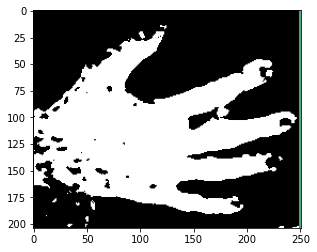

In [6]:
# This is how the machine sees your hand(or any object the motion of which you want to track)
from matplotlib.pyplot import imshow
from PIL import Image
imshow(Image.open("mask.PNG"))

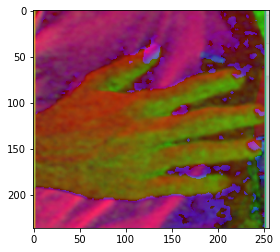

In [7]:
# This is how the world looks in HSV
imshow(Image.open("hsv.PNG"))

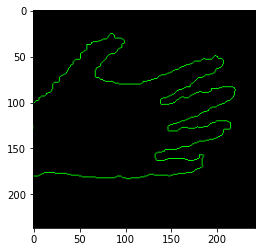

In [8]:
# This is how the countour around my hand looks like
imshow(Image.open("contour.PNG"))